In [ ]:
import numpy as np
import pandas as pd
from math import sqrt

from matplotlib import pyplot
from pandas import read_csv

from pandas import DataFrame
from pandas import concat

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
!pip install hydroeval
!pip install SGD


from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pywt
np.random.seed(2020)
from keras import regularizers, optimizers
from keras.models import Sequential, load_model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, LSTM, Bidirectional, BatchNormalization
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from keras.layers.core import Dense, Activation
from keras.regularizers import l1_l2, l2
from numpy import array
import warnings

import matplotlib.pyplot as plt
from keras import optimizers

from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df = pd.read_csv('final.csv')
df.head()

,Date,basantpur_rainfall,Andhiyarkhore,Bamnidhi,Simga,Ghatora,Rajim,Rampur,Basantpur
0,01-07-2001,21.944357,5.400,1350.000,35.00,150.000,160.000,108.000,2250.000
1,02-07-2001,3.318059,4.078,496.334,97.25,78.000,150.366,119.859,1353.260
2,03-07-2001,2.335704,3.071,163.761,105.40,35.327,62.633,68.933,1145.230
3,04-07-2001,7.705987,2.343,156.041,67.31,21.230,36.257,48.694,676.221
4,05-07-2001,31.771525,2.321,148.249,48.46,22.491,29.935,23.432,646.760


In [ ]:
cols=list(df)[1:9]
data=df[cols].astype(float)

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data= scaler.fit_transform(data)

In [ ]:
#converts col into different array
R,Qa,Qbi,Qs,Qg,Qr,Qrm,Qb =scaled_data.T

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  #n_vars = 1 if type(data) is list else data.shape[1]
  df = DataFrame(data)
  cols, names = list(), list()
# input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var(t-%d)' % (i))] #for j in range(n_vars)]
# forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var(t)')] #for j in range(n_vars)]
    else:
      names += [('var(t+%d)' % (i))] #for j in range(n_vars)]
# put it all together
  agg = concat(cols, axis=1)
  agg.columns = names
# drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

In [ ]:
#Is = series_to_supervised(I,4,2)
R = series_to_supervised(R,0,1)
Qas = series_to_supervised(Qa,1,1)
Qbis= series_to_supervised(Qbi,6,1)
Qss = series_to_supervised(Qs,2,1)
Qgs = series_to_supervised(Qg,5,1)
Qrs = series_to_supervised(Qr,1,1)
Qrms = series_to_supervised(Qrm,1,1)
Qbs = series_to_supervised(Qb,3,2)
#Rs = series_to_supervised(R,1,1)

In [ ]:
dfs=[R,Qas,Qbis,Qss,Qgs,Qrs,Qrms,Qbs]
Input=pd.concat(dfs,axis=1,keys=range(1,len(dfs)+1))
Input.columns = Input.columns.map('{0[1]}{0[0]}'.format)
Input = Input.iloc[6-0:] #change iloc only if u cange lag days
Input = Input.drop(Input.index[-1:])

In [ ]:
Input

,var(t)1,var(t-1)2,var(t)2,var(t-6)3,var(t-5)3,var(t-4)3,var(t-3)3,var(t-2)3,var(t-1)3,var(t)3,...,var(t)5,var(t-1)6,var(t)6,var(t-1)7,var(t)7,var(t-3)8,var(t-2)8,var(t-1)8,var(t)8,var(t+1)8
6,0.182478,0.006606,0.020403,0.173577,0.063028,0.019960,0.018960,0.017951,0.021439,0.052034,...,0.093190,0.011465,0.124113,0.002460,0.007934,0.020320,0.019429,0.021313,0.031854,0.039174
7,0.241542,0.020403,0.011954,0.063028,0.019960,0.018960,0.017951,0.021439,0.052034,0.031128,...,0.100879,0.124113,0.100364,0.007934,0.031897,0.019429,0.021313,0.031854,0.039174,0.129853
8,0.409743,0.011954,0.048305,0.019960,0.018960,0.017951,0.021439,0.052034,0.031128,0.032914,...,0.106219,0.100364,0.844190,0.031897,0.126150,0.021313,0.031854,0.039174,0.129853,0.473977
9,0.187636,0.048305,0.069608,0.018960,0.017951,0.021439,0.052034,0.031128,0.032914,0.066659,...,0.083371,0.844190,0.414098,0.126150,0.067826,0.031854,0.039174,0.129853,0.473977,0.302142
10,0.253682,0.069608,0.039898,0.017951,0.021439,0.052034,0.031128,0.032914,0.066659,0.068247,...,0.139594,0.414098,0.141782,0.067826,0.025491,0.039174,0.129853,0.473977,0.302142,0.144966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,0.049192,0.021112,0.018255,0.066747,0.052643,0.040070,0.031069,0.036486,0.052095,0.050553,...,0.119569,0.027269,0.017562,0.020225,0.013163,0.107042,0.022709,0.070436,0.060635,0.055443
1007,0.007834,0.018255,0.018253,0.052643,0.040070,0.031069,0.036486,0.052095,0.050553,0.043512,...,0.119777,0.017562,0.017530,0.013163,0.013151,0.022709,0.070436,0.060635,0.055443,0.048120
1008,0.000533,0.018253,0.014383,0.040070,0.031069,0.036486,0.052095,0.050553,0.043512,0.038290,...,0.074466,0.017530,0.019187,0.013151,0.012462,0.070436,0.060635,0.055443,0.048120,0.028554
1009,0.000100,0.014383,0.013407,0.031069,0.036486,0.052095,0.050553,0.043512,0.038290,0.023297,...,0.069168,0.019187,0.017202,0.012462,0.008213,0.060635,0.055443,0.048120,0.028554,0.023694


In [ ]:
y=Input[Input.columns[Input.columns.isin(['var(t+1)8'])]]

In [ ]:
y

,var(t+1)8
6,0.039174
7,0.129853
8,0.473977
9,0.302142
10,0.144966
...,...
1006,0.055443
1007,0.048120
1008,0.028554
1009,0.023694


In [ ]:
x=Input.drop(['var(t+1)8'],axis=1)

In [ ]:
x

,var(t)1,var(t-1)2,var(t)2,var(t-6)3,var(t-5)3,var(t-4)3,var(t-3)3,var(t-2)3,var(t-1)3,var(t)3,...,var(t-1)5,var(t)5,var(t-1)6,var(t)6,var(t-1)7,var(t)7,var(t-3)8,var(t-2)8,var(t-1)8,var(t)8
6,0.182478,0.006606,0.020403,0.173577,0.063028,0.019960,0.018960,0.017951,0.021439,0.052034,...,0.212395,0.093190,0.011465,0.124113,0.002460,0.007934,0.020320,0.019429,0.021313,0.031854
7,0.241542,0.020403,0.011954,0.063028,0.019960,0.018960,0.017951,0.021439,0.052034,0.031128,...,0.093190,0.100879,0.124113,0.100364,0.007934,0.031897,0.019429,0.021313,0.031854,0.039174
8,0.409743,0.011954,0.048305,0.019960,0.018960,0.017951,0.021439,0.052034,0.031128,0.032914,...,0.100879,0.106219,0.100364,0.844190,0.031897,0.126150,0.021313,0.031854,0.039174,0.129853
9,0.187636,0.048305,0.069608,0.018960,0.017951,0.021439,0.052034,0.031128,0.032914,0.066659,...,0.106219,0.083371,0.844190,0.414098,0.126150,0.067826,0.031854,0.039174,0.129853,0.473977
10,0.253682,0.069608,0.039898,0.017951,0.021439,0.052034,0.031128,0.032914,0.066659,0.068247,...,0.083371,0.139594,0.414098,0.141782,0.067826,0.025491,0.039174,0.129853,0.473977,0.302142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,0.049192,0.021112,0.018255,0.066747,0.052643,0.040070,0.031069,0.036486,0.052095,0.050553,...,0.123302,0.119569,0.027269,0.017562,0.020225,0.013163,0.107042,0.022709,0.070436,0.060635
1007,0.007834,0.018255,0.018253,0.052643,0.040070,0.031069,0.036486,0.052095,0.050553,0.043512,...,0.119569,0.119777,0.017562,0.017530,0.013163,0.013151,0.022709,0.070436,0.060635,0.055443
1008,0.000533,0.018253,0.014383,0.040070,0.031069,0.036486,0.052095,0.050553,0.043512,0.038290,...,0.119777,0.074466,0.017530,0.019187,0.013151,0.012462,0.070436,0.060635,0.055443,0.048120
1009,0.000100,0.014383,0.013407,0.031069,0.036486,0.052095,0.050553,0.043512,0.038290,0.023297,...,0.074466,0.069168,0.019187,0.017202,0.012462,0.008213,0.060635,0.055443,0.048120,0.028554


In [ ]:
x_train=x[:456]
x_val=x[456:639]
x_test=x[639:]
y_train=y[:456]
y_val=y[456:639]
y_test=y[639:]

In [ ]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape,x_val.shape,y_val.shape

((456, 27), (366, 27), (456, 1), (366, 1), (183, 27), (183, 1))

In [ ]:
#converting dataframe to array to reshape in next step
x_train=x_train.values
y_train=y_train.values
x_test=x_test.values
y_test=y_test.values
x_val=x_val.values
y_val=y_val.values

In [ ]:
#reshape into 3-D cz model cannot perform in 2-D
x_train = x_train.reshape((x_train.shape[0],x_train.shape[1],1))
x_val = x_val.reshape((x_val.shape[0],x_val.shape[1],1))
x_test = x_test.reshape((x_test.shape[0],x_test.shape[1],1))

In [ ]:
x_train.shape,x_test.shape,x_val.shape

((456, 27, 1), (366, 27, 1), (183, 27, 1))

In [ ]:
# model_cnn = Sequential()
# model_cnn.add(Conv1D(filters=64, kernel_size=2, padding = "same", strides = 1, activation = "relu",input_shape=(x_train.shape[0],1, x_train.shape[2])))
# model_cnn.add(Conv1D(filters=50, kernel_size=2, padding = "same", strides = 1, activation = "relu"))
# # model_cnn.add(TimeDistributed(MaxPooling1D(2)))
# model_cnn.add(TimeDistributed(Flatten()))
# # model_cnn.add(Dense(50, activation='relu'))
# model_cnn.add(Dense(1))
# model_cnn.compile(loss='mse', optimizer='adam')
# model_cnn.summary()
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer='adam')
model_cnn.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 26, 64)            192       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 13, 64)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 832)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                41650     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 41,893
Trainable params: 41,893
Non-trainable params: 0
__________________________________________________

In [ ]:
history = model_cnn.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, verbose=2)

Epoch 1/100
15/15 - 1s - loss: 0.0042 - val_loss: 0.0025 - 1s/epoch - 72ms/step
Epoch 2/100
15/15 - 0s - loss: 0.0020 - val_loss: 0.0021 - 125ms/epoch - 8ms/step
Epoch 3/100
15/15 - 0s - loss: 0.0013 - val_loss: 0.0020 - 121ms/epoch - 8ms/step
Epoch 4/100
15/15 - 0s - loss: 9.1446e-04 - val_loss: 0.0019 - 130ms/epoch - 9ms/step
Epoch 5/100
15/15 - 0s - loss: 8.1848e-04 - val_loss: 0.0019 - 122ms/epoch - 8ms/step
Epoch 6/100
15/15 - 0s - loss: 8.7316e-04 - val_loss: 0.0021 - 121ms/epoch - 8ms/step
Epoch 7/100
15/15 - 0s - loss: 0.0010 - val_loss: 0.0020 - 123ms/epoch - 8ms/step
Epoch 8/100
15/15 - 0s - loss: 6.9939e-04 - val_loss: 0.0017 - 125ms/epoch - 8ms/step
Epoch 9/100
15/15 - 0s - loss: 5.5417e-04 - val_loss: 0.0019 - 122ms/epoch - 8ms/step
Epoch 10/100
15/15 - 0s - loss: 4.8076e-04 - val_loss: 0.0019 - 126ms/epoch - 8ms/step
Epoch 11/100
15/15 - 0s - loss: 4.8751e-04 - val_loss: 0.0020 - 128ms/epoch - 9ms/step
Epoch 12/100
15/15 - 0s - loss: 4.2131e-04 - val_loss: 0.0019 - 120ms/

In [ ]:
hist_df = pd.DataFrame(history.history )
hist_df

,loss,val_loss
0,0.004195,0.002482
1,0.002010,0.002120
2,0.001286,0.002009
3,0.000914,0.001861
4,0.000818,0.001931
...,...,...
95,0.000142,0.001923
96,0.000114,0.001800
97,0.000104,0.001902
98,0.000075,0.001809


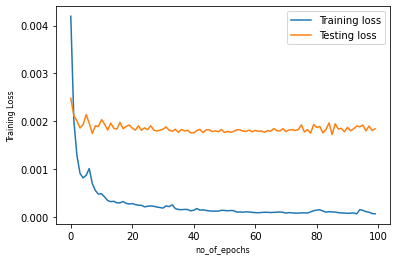

In [ ]:
plt.plot(history.history['loss'],label='Training loss' )
plt.plot(history.history['val_loss'], label='Testing loss')
plt.xlabel('no_of_epochs', fontsize=8 )
plt.ylabel('Training Loss', fontsize=8 )
plt.legend()

In [ ]:
train_yp = model_cnn.predict(x_train)
val_yp = model_cnn.predict(x_val)
test_yp =model_cnn.predict(x_test)

12/12 [==============================] - 0s 2ms/step


In [ ]:
x_train.shape

(456, 27, 1)

In [ ]:
#reshape into the origional form (2-D)
x_train = x_train.reshape((x_train.shape[0],x_train.shape[1]))
x_val= x_val.reshape((x_val.shape[0],x_val.shape[1]))
x_test= x_test.reshape((x_test.shape[0],x_test.shape[1]))

train_yp = train_yp.reshape((train_yp.shape[0],train_yp.shape[1]))
val_yp= val_yp.reshape((val_yp.shape[0],val_yp.shape[1]))
test_yp= test_yp.reshape((test_yp.shape[0],test_yp.shape[1]))

In [ ]:
x_train.shape, x_val.shape,x_test.shape

((456, 27), (183, 27), (366, 27))

In [ ]:
#inverse_transform
#1)x_train
inv_x_train=pd.concat([pd.DataFrame(train_yp), pd.DataFrame(x_train[:, :7])], axis=1)
rev_trans=scaler.inverse_transform(inv_x_train) 
y_train_prediction=rev_trans[:,0]

#y_train
inv_y_train=pd.concat([pd.DataFrame(y_train), pd.DataFrame(x_train[:, :7])], axis=1)
rev_trans=scaler.inverse_transform(inv_y_train) 
y_train_Observed=rev_trans[:,0]

#x_val
inv_x_val=pd.concat([pd.DataFrame(val_yp), pd.DataFrame(x_train[:, :7])], axis=1)
rev_trans=scaler.inverse_transform(inv_x_val) 
y_val_prediction=rev_trans[:,0]

#y_val
inv_y_val=pd.concat([pd.DataFrame(y_val), pd.DataFrame(x_train[:, :7])], axis=1)
rev_trans=scaler.inverse_transform(inv_y_val) 
y_val_Observed=rev_trans[:,0]

#x_test
inv_x_test=pd.concat([pd.DataFrame(test_yp), pd.DataFrame(x_train[:, :7])], axis=1)
rev_trans=scaler.inverse_transform(inv_x_test) 
y_test_prediction=rev_trans[:,0]

#y_test
inv_y_test=pd.concat([pd.DataFrame(y_test), pd.DataFrame(x_train[:, :7])], axis=1)
rev_trans=scaler.inverse_transform(inv_y_test) 
y_test_Observed=rev_trans[:,0]

In [ ]:
y_test_prediction.shape, y_test_Observed.shape

((456,), (456,))

<Axes: >

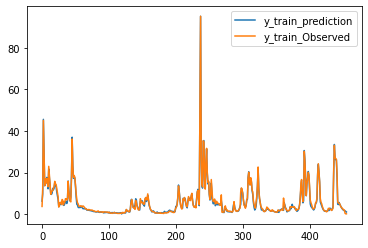

In [ ]:
y_train_pre=np.array(y_train_prediction)
y_train_rev=np.array(y_train_Observed)
l=np.array([y_train_prediction,y_train_Observed])
dataset=pd.DataFrame(l)
dataset=dataset.transpose()
dataset.columns = ['y_train_prediction', 'y_train_Observed']
dataset[['y_train_prediction','y_train_Observed']].plot()

In [ ]:
from hydroeval import evaluator, nse

NSE_train = evaluator(nse,y_train_prediction , y_train_Observed )
print(NSE_train)

[0.98967508]


<Axes: >

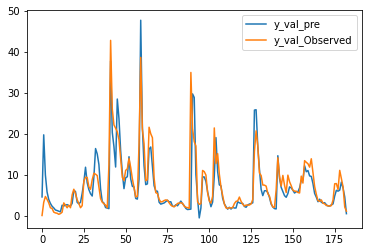

In [ ]:
y_val_pre=np.array(y_val_prediction)
y_val_Observed=np.array(y_val_Observed)
l=np.array([y_val_prediction,y_val_Observed])
dataset_val=pd.DataFrame(l)
dataset_val=dataset_val.transpose()
dataset_val.columns = ['y_val_pre', 'y_val_Observed']
dataset_val[['y_val_pre','y_val_Observed']].plot()

In [ ]:
NSE_val = evaluator(nse,y_val_pre , y_val_Observed )
print(NSE_val)

[0.64043155]


<Axes: >

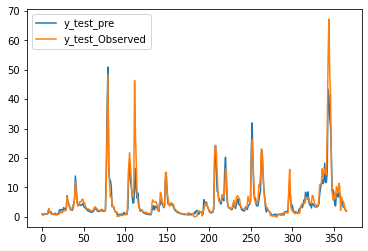

In [ ]:
#test
y_test_pre=np.array(y_test_prediction)
y_test_Observed=np.array(y_test_Observed)
l=np.array([y_test_prediction,y_test_Observed])
dataset=pd.DataFrame(l)
dataset_test=dataset.transpose()
dataset_test.columns = ['y_test_pre', 'y_test_Observed']
dataset_test[['y_test_pre','y_test_Observed']].plot()

In [ ]:
from hydroeval import evaluator, nse

NSE_test = evaluator(nse,y_test_pre , y_test_Observed )
#NSE_test = evaluator( nse,predicted_test_saved ,observed_y__test_saved  )

print(NSE_test)

[0.83182829]


<ipython-input-72-0c9bb32ffde3>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_lim, y_lim, 'k-', color = 'black', label = '1:1 line')


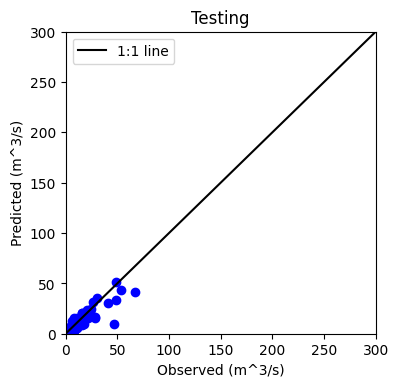

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4), dpi=100)
plt.scatter(y_test_Observed,y_test_pre, color='b')
y_lim = plt.ylim([0, 300])
x_lim = plt.ylim([0, 300])
plt.plot(x_lim, y_lim, 'k-', color = 'black', label = '1:1 line')
plt.ylim(y_lim)
plt.xlim(x_lim)
plt.title('Testing')
plt.xlabel("Observed (m^3/s)")
plt.ylabel("Predicted (m^3/s)")
plt.legend()

In [ ]:
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error
np.random.seed(2020)
from hydroeval import evaluator,nse,kge,kgeprime,rmse,mare,pbias

NSE_train = evaluator(nse,y_train_prediction , y_train_Observed )
NSE_val = evaluator(nse,y_val_pre , y_val_Observed )
NSE_test = evaluator(nse,y_test_pre , y_test_Observed )

RMSE_Training =evaluator(rmse,y_train_prediction , y_train_Observed)
RMSE_val = evaluator(rmse,y_val_pre, y_val_Observed)
RMSE_Testing = evaluator(rmse,y_test_pre , y_test_Observed)


MARE_Training =evaluator(mare,y_train_pre,y_train_Observed)
MARE_val = evaluator(mare,y_val_pre, y_val_Observed)
MARE_Testing = evaluator(mare,y_test_pre , y_test_Observed)
    
    
PBIAS_Training =evaluator(pbias,y_train_pre ,y_train_Observed)
PBIAS_val = evaluator(pbias,y_val_pre, y_val_Observed)
PBIAS_Testing = evaluator(pbias,y_test_pre , y_test_Observed)
    
    
# corr_train ,p_value_train = pearsonr(y_train_pre, y_train_Observed)
# corr_test ,p_value_test = pearsonr(y_test_pre,  y_test_Observed)
    
        
# mae_train = mean_absolute_error(y_train_Observed, y_train_pre) 
# mae_test = mean_absolute_error( y_test_Observed,y_test_pre) 
    
v_error_train = (np.sum(y_train_pre)-np.sum(y_train_Observed))/np.sum(y_train_Observed)
v_error_val  = (np.sum(y_val_pre)-np.sum(y_val_Observed))/np.sum(y_val_Observed) 
v_error_test  = (np.sum(y_test_pre)-np.sum(y_test_Observed))/np.sum(y_test_Observed)   

In [ ]:
results=[NSE_train,NSE_val,NSE_test,RMSE_Training,RMSE_val,RMSE_Testing, MARE_Training,MARE_val,MARE_Testing, PBIAS_Training,PBIAS_val,PBIAS_Testing,v_error_train,v_error_val,v_error_test]
l=np.array([results])
res=pd.DataFrame(l).transpose()
res

<ipython-input-74-dd8356cd6518>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  l=np.array([results])


,0
0,[0.9896750840730261]
1,[0.6404315450271674]
2,[0.8318282940241968]
3,[0.8368271594416362]
4,[4.085738364686708]
5,[3.2438248403050802]
6,[0.08608732863147116]
7,[0.2723741000762498]
8,[0.2494589385000862]
9,[3.3695539097432077]


In [ ]:
res.to_csv('cnn1_rcf.csv')

In [ ]:
#grid search